# Features de TextMining:

---------------------------------

### Importando dependências

!pip install streamlit-aggrid --user

In [1]:
import os
import sys
import re
import datetime
import dateutil

sys.path.insert(0,os.path.dirname(os.getcwd()))
sys.path.insert(0,os.path.join(os.getcwd(),'grobid'))
sys.path.insert(0,os.getcwd())

import numpy as np
import pandas as pd

from grobid import grobid_client
import grobid_tei_xml
from grobid_to_dataframe import grobid_cli, xmltei_to_dataframe

import plotly

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from pyvis.network import Network

!pip install nltk --upgrade

!pip install gensim --upgrade

!pip install spacy --upgrade

!pip install stanford-corenlp --upgrade

!pip install corenlp --upgrade

!pip install textblob --upgrade

!pip install transformers --upgrade

!pip install pyvis

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

---------------------------------

### Comandos Docker

docker run -t --rm --init -p 8080:8070 -p 8081:8071 --memory="9g" lfoppiano/grobid:0.7.0

docker run -t --rm --init -p 8080:8070 -p 8081:8071 lfoppiano/grobid:0.6.2

pip install grobid-tei-xml

### Definindo variáveis e caminhos

In [3]:
path = os.path.dirname(os.getcwd())
path_input = os.path.join(path,'artifacts','articles','ml_material','teste')

---------------------------------

### Funções para execução em batch

In [4]:
def get_path(path_input_path):
    """"""
    if os.path.exists(path_input_path):
        return path_input_path
    
    return os.getcwd()


def batch_process_path(path_input_path, n_workers=2,
                       check_cache=True,
                       cache_folder_name='summarticles_cache',
                       config_path="./grobid/config.json"):
    
    """"""
    
    gcli = grobid_cli(config_path=config_path)
    result_batch = gcli.process_pdfs(input_path=path_input_path,
                                     check_cache=check_cache,
                                     cache_folder_name=cache_folder_name,
                                     n_workers=n_workers,
                                     service="processFulltextDocument",
                                     generateIDs=True,
                                     include_raw_citations=True,
                                     include_raw_affiliations=True,
                                     consolidate_header=False,
                                     consolidate_citations=False,
                                     tei_coordinates=False,
                                     segment_sentences=True,
                                     verbose=True)
    return result_batch


def get_dataframes(result_batch):
    
    """"""
    
    xml_to_df = xmltei_to_dataframe()
    dict_dfs, dic_errors = xml_to_df.get_dataframe_articles(result_batch)
    
    return dict_dfs, dic_errors


def files_path(path):
    list_dir = os.listdir(path)
    files = []
    for file in list_dir:
        if os.path.isfile(os.path.join(path,file)):
            files.append(os.path.join(path,file))
    return files

In [5]:
def run_batch_process(path_input, n_workers=6, check_cache=True, 
                      cache_folder_name='summarticles_cache', 
                      config_path="./grobid/config.json"):

    dict_exec = {'path':path_input}
    dict_exec['start_datetime'] = datetime.datetime.now()
    
    # path_input = os.path.join(path,'artifacts','test_article')
    config_path = os.path.join(os.getcwd(),'grobid','config.json')
    dict_exec['grobid_config'] = config_path
    
    gcli = grobid_client.GrobidClient(config_path=config_path, check_server=False)
    
    dict_exec['files'] = gcli.get_input_files(path_input)
    dict_exec['num_files'] = len(dict_exec['files'])
    dict_exec['n_workers'] = n_workers
    
    path_input_path = get_path(path_input)
    result_batch = batch_process_path(path_input_path, n_workers=dict_exec['n_workers'], check_cache=check_cache)
    dict_dfs, dic_errors = get_dataframes(result_batch)
    
    gcli.save_xmltei_files(result_batch, input_folder_path, cache_folder_name=cache_folder_name)
    
    dict_exec['end_datetime'] = datetime.datetime.now()
    dict_exec['time_exec_sec'] = (dict_exec['end_datetime']-dict_exec['start_datetime']).seconds
    dict_exec['time_exec_min'] = (dict_exec['end_datetime']-dict_exec['start_datetime']).seconds
    
    return dict_dfs, dict_exec, dic_errors

In [6]:
input_folder_path = r"""C:\Users\vierb\OneDrive\Área de Trabalho\Projetos\PGC\artifacts\articles\ml_material"""

In [7]:
%%time
dict_dfs, dict_exec, dic_errors = run_batch_process(path_input=input_folder_path, 
                                                    n_workers=10, 
                                                    check_cache=True, 
                                                    cache_folder_name='summarticles_cache', 
                                                    config_path="./grobid/config.json")

GROBID server is up and running
587 files to process in current batch
[Input Files] 587
[Cache Files] 587
In the end, we have: 0  new files to process!
And we have : 587  files to back from cache!
Processed articles: 581
Number articles with errors: 6
Wall time: 22.3 s


In [8]:
print(dict_exec.keys())

dict_keys(['path', 'start_datetime', 'grobid_config', 'files', 'num_files', 'n_workers', 'end_datetime', 'time_exec_sec', 'time_exec_min'])


In [9]:
dic_errors

{'number_article_error': 6,
 'list_article_error': [{'file': 'C:\\Users\\vierb\\OneDrive\\Área de Trabalho\\Projetos\\PGC\\artifacts\\articles\\ml_material\\j.commatsci.2020.110166.pdf',
   'error': ValueError,
   'error_text': 'If using all scalar values, you must pass an index'},
  {'file': 'C:\\Users\\vierb\\OneDrive\\Área de Trabalho\\Projetos\\PGC\\artifacts\\articles\\ml_material\\j.commatsci.2020.109782.pdf',
   'error': xml.etree.ElementTree.ParseError,
   'error_text': 'syntax error: line 1, column 0'},
  {'file': 'C:\\Users\\vierb\\OneDrive\\Área de Trabalho\\Projetos\\PGC\\artifacts\\articles\\ml_material\\S1006-706X(14)60038-8.pdf',
   'error': ValueError,
   'error_text': 'If using all scalar values, you must pass an index'},
  {'file': 'C:\\Users\\vierb\\OneDrive\\Área de Trabalho\\Projetos\\PGC\\artifacts\\articles\\ml_material\\advs.201903667.pdf',
   'error': ValueError,
   'error_text': 'If using all scalar values, you must pass an index'},
  {'file': 'C:\\Users\\vier

In [10]:
dict_dfs['df_doc_info'].head(3).T

pdf_md5,39C614A80AE3DB1C491808B5F4368DE0,43635A886CDF0511DE3914D4639F3A2F,39B3218D2D1F1BF589CB94AF16E3D614
grobid_version,0.7.0,0.7.0,0.7.0
grobid_timestamp,2022-05-15 02:11:00,2022-05-15 02:09:00,2022-05-15 02:11:00
language_code,en,en,en
acknowledgement,NaN,Acknowledgements,Acknowledgements The authors would like to tha...
abstract,One of the most exciting tools that have enter...,We evaluate the performance of a popular machi...,The design of new materials with useful proper...
body,"INTRODUCTION In recent years, the availability...",Introduction Substitutional solute diffusion i...,Introduction Science is in an exponential worl...
annex,NaN,NaN,NaN
file,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...
status,status 200,status 200,status 200
raw_data,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x..."


In [11]:
dict_dfs['df_doc_head'].head(3).T

pdf_md5,39C614A80AE3DB1C491808B5F4368DE0,43635A886CDF0511DE3914D4639F3A2F,39B3218D2D1F1BF589CB94AF16E3D614
index_head,NaN,NaN,NaN
id_head,NaN,NaN,NaN
unstructured_head,NaN,NaN,NaN
date_head,NaN,NaN,2018-12-15
title_head,Recent advances and applications of machine le...,Computational Materials Science,Materials Science & Engineering A
book_title_head,NaN,NaN,NaN
series_title_head,NaN,NaN,NaN
journal_head,NaN,NaN,NaN
journal_abbrev_head,NaN,NaN,NaN
publisher_head,NaN,NaN,NaN


In [12]:
dict_dfs['df_doc_authors'].head(3).T

pdf_md5,39C614A80AE3DB1C491808B5F4368DE0,39C614A80AE3DB1C491808B5F4368DE0,39C614A80AE3DB1C491808B5F4368DE0
full_name_author,Jonathan Schmidt,Mário R G Marques,Silvana Botti
given_name_author,Jonathan,Mário,Silvana
middle_name_author,NaN,R G,NaN
surname_author,Schmidt,Marques,Botti
email_author,NaN,NaN,NaN
orcid_author,0000-0001-5685-6404,0000-0002-7420-5098,NaN
institution_author,Martin-Luther-Universität,Martin-Luther-Universität,Friedrich-Schiller-Universität Jena
department_author,Institut für Physik,Institut für Physik,Institut für Festkörpertheorie und -optik
laboratory_author,NaN,NaN,NaN
addr_line_author,NaN,NaN,Max-Wien-Platz 1


In [13]:
dict_dfs['df_doc_citations'].head(5)

,index_citation,id_citation,unstructured_citation,date_citation,title_citation,book_title_citation,series_title_citation,journal_citation,journal_abbrev_citation,publisher_citation,...,first_page_citation,last_page_citation,note_citation,doi_citation,pmid_citation,pmcid_citation,arxiv_id_citation,ark_citation,istex_id_citation,url_citation
pdf_md5,,,,,,,,,,,,,,,,,,,,,
39C614A80AE3DB1C491808B5F4368DE0,0,b0,"Marsland, S. Machine Learning (CRC Press, Tayl...",2014,NaN,NaN,NaN,NaN,NaN,CRC Press,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39C614A80AE3DB1C491808B5F4368DE0,1,b1,"Silver, D. et al. Mastering the game of go wit...",2016,Mastering the game of go with deep neural netw...,NaN,NaN,Nature,NaN,NaN,...,484,489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39C614A80AE3DB1C491808B5F4368DE0,2,b2,"Bojarski, M. et al. End to end learning for se...",2016,End to end learning for self-driving cars,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1604.07316,NaN,NaN,NaN
39C614A80AE3DB1C491808B5F4368DE0,3,b3,"He, K., Zhang, X., Ren, S. & Sun, J. Delving d...",2015,Delving deep into rectifiers: surpassing human...,2015 IEEE International Conference on Computer...,NaN,NaN,NaN,IEEE,...,1026,1034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39C614A80AE3DB1C491808B5F4368DE0,4,b4,"Liu, S.-S. & Tian, Y.-T. Facial expression rec...",2010,Facial expression recognition method based on ...,Advances in Neural Networks -ISNN 2010,NaN,NaN,NaN,Springer,...,144,151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
dict_dfs['df_doc_authors_citations'].head(5)

,id,index,full_name_citation,given_name_citation,middle_name_citation,surname_citation,email_citation,orcid_citation,institution_citation,department_citation,laboratory_citation,addr_line_citation,post_code_citation,settlement_citation,country_citation
pdf_md5,,,,,,,,,,,,,,,
39C614A80AE3DB1C491808B5F4368DE0,b0,0,S Machine Marsland,S,Machine,Marsland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39C614A80AE3DB1C491808B5F4368DE0,b0,0,Learning,NaN,NaN,Learning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39C614A80AE3DB1C491808B5F4368DE0,b1,1,D Silver,D,NaN,Silver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39C614A80AE3DB1C491808B5F4368DE0,b2,2,M Bojarski,M,NaN,Bojarski,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39C614A80AE3DB1C491808B5F4368DE0,b3,3,K He,K,NaN,He,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---------------------------------

### Trabalhando no tratamento do texto

!pip install pytorch --upgrade

!pip install tensorflow --upgrade --user

In [15]:
import nltk
import spacy
import corenlp
import textblob
import gensim
#import transformers

In [16]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vierb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vierb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vierb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\vierb\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

--------------------------------

Estudando a distribuição de caracteres especiais:

In [20]:
list_chars = []
for id,row in dict_dfs['df_doc_info'].iterrows():
    for c in row['raw_data']:
        list_chars.append(c)
        
df_counts = pd.DataFrame({'chars':pd.value_counts(list_chars).index.tolist(),'counts':pd.value_counts(list_chars).tolist()})
df_counts = df_counts.sort_values(by='counts',ascending=False)

import plotly.express as px
fig = px.bar(df_counts.head(20), x='chars', y='counts')
fig.show()

In [21]:
df_counts.sort_values(by='counts',ascending=False).tail(30)

,chars,counts
741,Ⅰ,1
740,Ḟ,1
739,⊤,1
742,ℤ,1
749,͵,1
760,,1
726,≳,1
750,𝑪,1
752,݊,1
753,ቀ,1


--------------------------------

Tratando texto:

In [22]:
def text_tokenize(text, language='english', preserve_line=False):
    return nltk.tokenize.word_tokenize(text, language=language, preserve_line=preserve_line)

def clean_text_regex(words_list, regex="[^a-zA-Z]+", replace='', min_word_len=1):
    """Testado em https://regex101.com/"""
    new_words = []
    for word in words_list:
        word = re.sub(regex, replace, word)
        if len(word) > min_word_len:
            new_words.append(word)
    return new_words

def remove_stopwords(words_list, stopwords_list):
    """"""
    new_words = []
    for word in words_list:
        if word not in stopwords_list:
            new_words.append(word)
    return new_words

def lemmatizer(words_list):
    """"""
    obj_lemmatizer = nltk.stem.WordNetLemmatizer()
    words_lemma = []
    for word in words_list:
        words_lemma.append(obj_lemmatizer.lemmatize(word,pos=nltk.corpus.wordnet.VERB))
    return words_lemma

def stem_text(words_list):
    """"""
    p_stem = nltk.stem.PorterStemmer()
    words_stem = []
    for word in words_list:
        words_stem.append(p_stem.stem(word))
    return words_stem

In [23]:
def text_prep(text, clean_text=True, stopwords_remove=True, exec_lemmatizer=True, exec_stem=False, text_lower=False, stopwords_list=[], language='english',
              preserve_line=False, regex_chars_clean="[^a-zA-Z]+", replace_chars_clean='', min_word_len=1):
    
    """Text preparation."""
    
    text_preparation = text_tokenize(text, language=language, preserve_line=preserve_line)
    if clean_text:
        text_preparation = clean_text_regex(words_list=text_preparation,
                                            regex=regex_chars_clean,
                                            replace=replace_chars_clean,
                                            min_word_len=min_word_len)
    if stopwords_remove:
        text_preparation = remove_stopwords(words_list=text_preparation,
                                            stopwords_list=stopwords_list)
    if exec_lemmatizer:
        text_preparation = lemmatizer(words_list=text_preparation)
    if exec_stem:
        text_preparation = stem_text(words_list=text_preparation)
    text_preparation = ' '.join(text_preparation)
    if text_lower:
        text_preparation = text_preparation.lower()
    return text_preparation

In [24]:
def text_prep_column(colum_df):
    """"""
    f_prep_text = lambda text_data: text_prep(text=text_data, clean_text=True, stopwords_remove=True, exec_lemmatizer=True, exec_stem=False, 
                                            stopwords_list=nltk.corpus.stopwords.words('english'), language='english', preserve_line=False,
                                            regex_chars_clean="[^a-zA-Z]+", replace_chars_clean='', min_word_len=1, text_lower=True)
    colum_df = colum_df.apply(lambda e: e if pd.isna(e) else f_prep_text(e))
    return colum_df

In [25]:
dict_dfs['df_doc_info'].abstract.iat[0]

'One of the most exciting tools that have entered the material science toolbox in recent years is machine learning. This collection of statistical methods has already proved to be capable of considerably speeding up both fundamental and applied research. At present, we are witnessing an explosion of works that develop and apply machine learning to solid-state systems. We provide a comprehensive overview and analysis of the most recent research in this topic. As a starting point, we introduce machine learning principles, algorithms, descriptors, and databases in materials science. We continue with the description of different machine learning approaches for the discovery of stable materials and the prediction of their crystal structure. Then we discuss research in numerous quantitative structure-property relationships and various approaches for the replacement of first-principle methods by machine learning. We review how active learning and surrogate-based optimization can be applied to

In [26]:
text_prep(text=dict_dfs['df_doc_info'].abstract.iat[0],
          clean_text=True,
          stopwords_remove=True,
          exec_lemmatizer=True,
          exec_stem=False,
          text_lower=True,
          stopwords_list=nltk.corpus.stopwords.words('english'),
          language='english',
          preserve_line=False,
          regex_chars_clean="[^a-zA-Z]+",
          replace_chars_clean='',
          min_word_len=1)

'one excite tool enter material science toolbox recent years machine learn this collection statistical methods already prove capable considerably speed fundamental apply research at present witness explosion work develop apply machine learn solidstate systems we provide comprehensive overview analysis recent research topic as start point introduce machine learn principles algorithms descriptors databases materials science we continue description different machine learn approach discovery stable materials prediction crystal structure then discuss research numerous quantitative structureproperty relationships various approach replacement firstprinciple methods machine learn we review active learn surrogatebased optimization apply improve rational design process relate examples applications two major question always interpretability physical understand gain machine learn model we consider therefore different facets interpretability importance materials science finally propose solutions fu

In [27]:
dict_dfs['df_doc_info'].head(3).T

pdf_md5,39C614A80AE3DB1C491808B5F4368DE0,43635A886CDF0511DE3914D4639F3A2F,39B3218D2D1F1BF589CB94AF16E3D614
grobid_version,0.7.0,0.7.0,0.7.0
grobid_timestamp,2022-05-15 02:11:00,2022-05-15 02:09:00,2022-05-15 02:11:00
language_code,en,en,en
acknowledgement,NaN,Acknowledgements,Acknowledgements The authors would like to tha...
abstract,One of the most exciting tools that have enter...,We evaluate the performance of a popular machi...,The design of new materials with useful proper...
body,"INTRODUCTION In recent years, the availability...",Introduction Substitutional solute diffusion i...,Introduction Science is in an exponential worl...
annex,NaN,NaN,NaN
file,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...
status,status 200,status 200,status 200
raw_data,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x..."


In [28]:
dict_dfs['df_doc_info']['acknowledgement_prep'] = text_prep_column(dict_dfs['df_doc_info']['acknowledgement'])
dict_dfs['df_doc_info']['abstract_prep'] = text_prep_column(dict_dfs['df_doc_info']['abstract'])
dict_dfs['df_doc_info']['body_prep'] = text_prep_column(dict_dfs['df_doc_info']['body'])

In [29]:
dict_dfs['df_doc_info'].head(3).T

pdf_md5,39C614A80AE3DB1C491808B5F4368DE0,43635A886CDF0511DE3914D4639F3A2F,39B3218D2D1F1BF589CB94AF16E3D614
grobid_version,0.7.0,0.7.0,0.7.0
grobid_timestamp,2022-05-15 02:11:00,2022-05-15 02:09:00,2022-05-15 02:11:00
language_code,en,en,en
acknowledgement,NaN,Acknowledgements,Acknowledgements The authors would like to tha...
abstract,One of the most exciting tools that have enter...,We evaluate the performance of a popular machi...,The design of new materials with useful proper...
body,"INTRODUCTION In recent years, the availability...",Introduction Substitutional solute diffusion i...,Introduction Science is in an exponential worl...
annex,NaN,NaN,NaN
file,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...
status,status 200,status 200,status 200
raw_data,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x..."


--------------------------------

Word Cloud:

!pip install wordcloud

In [30]:
from wordcloud import WordCloud
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sb

In [31]:
def word_cloud(documents, width=1000, height=200, collocations=True, background_color='white'):
    """Create and plot a wordcloud from documents list."""
    objWC = WordCloud(collocations=collocations, background_color=background_color, width=width, height=height)
    text = ' '.join([ ' ' if pd.isna(t) else t for t in documents])
    objWC = objWC.generate_from_text(text)
    ax = plt.imshow(objWC)
    plt.axis("off")
    plt.show()

In [32]:
documents = dict_dfs['df_doc_info']['abstract_prep'].fillna(' ').tolist()

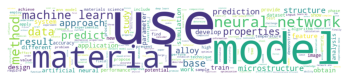

In [33]:
word_cloud(documents, width=1000, height=200, collocations=True, background_color='white')

In [34]:
documents_abs = dict_dfs['df_doc_info']['abstract_prep'].fillna(' ').tolist()
documents_body = dict_dfs['df_doc_info']['body_prep'].fillna(' ').tolist()
documents_all_text = [' '.join([abst, body]) for abst, body in zip(documents_abs, documents_body)]

In [35]:
def text_statistics(text):
    
    """"""
    
    dictStats = {}
    dictStats['num_chars'] = len(text)
    list_tokens = text_tokenize(str(text))
    dictStats['num_words'] = len(list_tokens)
    dictStats['num_words_unique'] = len(set(list_tokens))
    
    len_words = pd.Series([len(w) for w in list_tokens]).describe().to_dict()
    dictStats['mean_lenght_word'] = len_words['mean']
    dictStats['min_lenght_word'] = len_words['min']
    dictStats['max_lenght_word'] = len_words['max']
    dictStats['std_lenght_word'] = len_words['std']
    dictStats['first_quartile_lenght_word'] = len_words['25%']
    dictStats['second_quartile_median_lenght_word'] = len_words['50%']
    dictStats['third_quartile_lenght_word'] = len_words['75%']
    
    return dictStats

In [36]:
df_articles_stats = pd.DataFrame(list(map(lambda e: text_statistics(e), documents_all_text)))

In [37]:
token_text = text_tokenize(' '.join(documents_all_text))

In [38]:
words_freq = pd.value_counts(token_text)
words_freq = pd.DataFrame(words_freq,columns=['frequency'])
words_freq.index.name = 'word'
words_freq = words_freq.reset_index()

words_freq.head()

,word,frequency
0,the,31896
1,model,26780
2,use,22826
3,fig,17820
4,data,15962


In [39]:
list_bigrams = list(nltk.bigrams(token_text))
bigram_freq = pd.value_counts(list_bigrams)
df_bigram = pd.DataFrame(bigram_freq, columns=['frequency'])
df_bigram.index.name = 'bigram'
df_bigram = df_bigram.reset_index()

df_bigram.head()

,bigram,frequency
0,"(neural, network)",4955
1,"(fig, fig)",4054
2,"(et, al)",3844
3,"(machine, learn)",3525
4,"(show, fig)",2442


In [40]:
list_trigam = list(nltk.trigrams(token_text))
trigam_freq = pd.value_counts(list_trigam)
df_trigram = pd.DataFrame(trigam_freq, columns=['frequency'])
df_trigram.index.name = 'trigram'
df_trigram = df_trigram.reset_index()

df_trigram.head()

,trigram,frequency
0,"(none, none, none)",1229
1,"(artificial, neural, network)",1019
2,"(neural, network, model)",578
3,"(machine, learn, model)",561
4,"(show, fig, the)",465


In [41]:
pd.value_counts(list_bigrams)

(neural, network)               4955
(fig, fig)                      4054
(et, al)                        3844
(machine, learn)                3525
(show, fig)                     2442
                                ... 
(ra, maximum)                      1
(valley, height)                   1
(height, rz)                       1
(bpnn, give)                       1
(electronegativity, valency)       1
Length: 841255, dtype: int64

In [42]:
df_articles_stats.head()

,num_chars,num_words,num_words_unique,mean_lenght_word,min_lenght_word,max_lenght_word,std_lenght_word,first_quartile_lenght_word,second_quartile_median_lenght_word,third_quartile_lenght_word
0,117072,14909,2628,6.852505,2.0,87.0,3.175050,5.0,7.0,9.0
1,13032,1850,530,6.044865,2.0,17.0,2.957174,4.0,6.0,8.0
2,21071,2643,772,6.972758,2.0,38.0,3.378699,5.0,7.0,9.0
3,19219,2521,796,6.623959,2.0,20.0,2.816019,4.0,6.0,8.0
4,23619,3199,752,6.383557,2.0,31.0,3.275660,4.0,6.0,8.0


In [43]:
dict_agg_stats = {}

# Chars
dict_agg_stats['num_total_chars'] = df_articles_stats['num_chars'].sum()
dict_agg_stats['num_mean_chars'] = df_articles_stats['num_chars'].mean()
dict_agg_stats['num_min_chars'] = df_articles_stats['num_chars'].min()
dict_agg_stats['num_max_chars'] = df_articles_stats['num_chars'].max()

# num_words
dict_agg_stats['num_total_words'] = df_articles_stats['num_words'].sum()
dict_agg_stats['num_mean_words'] = df_articles_stats['num_words'].mean()
dict_agg_stats['num_min_words'] = df_articles_stats['num_words'].min()
dict_agg_stats['num_max_chars'] = df_articles_stats['num_words'].max()

# num_words_unique
dict_agg_stats['num_total_words_unique'] = df_articles_stats['num_words'].sum()
dict_agg_stats['num_mean_words_unique'] = df_articles_stats['num_words'].mean()
dict_agg_stats['num_min_words_unique'] = df_articles_stats['num_words'].min()
dict_agg_stats['num_max_chars_unique'] = df_articles_stats['num_words'].max()

# mean_lenght_word
dict_agg_stats['mean_length_words'] = df_articles_stats['mean_lenght_word'].mean()

# mean_lenght_word
dict_agg_stats['lexical_density'] = dict_agg_stats['num_mean_words']/dict_agg_stats['num_mean_words_unique']
    

--------------------------------

Criando BOW e TFIDF:

In [44]:
documents = dict_dfs['df_doc_info']['abstract_prep'].fillna(' ').tolist()

In [45]:
obj_bow = CountVectorizer(encoding="utf-8",
                          stop_words="english",
                          strip_accents="ascii",
                          lowercase=True, 
                          preprocessor=None,
                          tokenizer=None,
                          token_pattern=r"""(?u)\b\w\w+\b""",
                          ngram_range=(1,2), # Unigram and bigram
                          analyzer="word",
                          max_df=1.0,
                          min_df=2, # May have at least 2 frequency
                          max_features=None, 
                          vocabulary= None, 
                          binary=False, 
                          dtype=np.int64)

obj_tfidf = TfidfVectorizer(encoding="utf-8",
                            stop_words="english",
                            strip_accents="ascii",
                            lowercase=True, 
                            preprocessor=None,
                            tokenizer=None,
                            token_pattern=r"""(?u)\b\w\w+\b""",
                            ngram_range=(1,2), # Unigram and bigram
                            analyzer="word",
                            max_df=1.0,
                            min_df=2, # May have at least 2 frequency
                            max_features=None, 
                            vocabulary= None, 
                            binary=False, 
                            dtype=np.float64, 
                            norm='l2', 
                            use_idf=True, 
                            smooth_idf=True, 
                            sublinear_tf=False)

obj_bow = obj_bow.fit(raw_documents=documents)
bow_matrix = obj_bow.transform(documents)

obj_tfidf = obj_tfidf.fit(raw_documents=documents)
tfidf_matrix = obj_tfidf.transform(documents)

bow_matrix = bow_matrix.todense()
tfidf_matrix = tfidf_matrix.todense()

df_bow = pd.DataFrame(bow_matrix, columns=obj_bow.get_feature_names())
df_tfidf = pd.DataFrame(tfidf_matrix, columns=obj_tfidf.get_feature_names())

In [46]:
df_bow.head(3)

,aa,aa aluminum,aare,ab,ab initio,abaqus,abilities,ability,ability feasible,ability gfa,...,zirconia,zn,zn alloy,zn coat,zncl,zone,zone fz,zr,zr hf,zro
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
df_tfidf.head(3)

,aa,aa aluminum,aare,ab,ab initio,abaqus,abilities,ability,ability feasible,ability gfa,...,zirconia,zn,zn alloy,zn coat,zncl,zone,zone fz,zr,zr hf,zro
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


--------------------------------

Trabalhando com a similaridade de Cosseno:

In [48]:
cos_bow_sim = cosine_similarity(df_bow, df_bow)
cos_tfidf_sim = cosine_similarity(df_tfidf, df_tfidf)

df_cos_bow_sim = pd.DataFrame(cos_bow_sim,
                              columns=dict_dfs['df_doc_info'].index.tolist(),
                              index=dict_dfs['df_doc_info'].index.tolist())

df_cos_tfidf_sim = pd.DataFrame(cos_tfidf_sim,
                                columns=dict_dfs['df_doc_info'].index.tolist(),
                                index=dict_dfs['df_doc_info'].index.tolist())

In [49]:
df_cos_bow_sim.head()

,39C614A80AE3DB1C491808B5F4368DE0,43635A886CDF0511DE3914D4639F3A2F,39B3218D2D1F1BF589CB94AF16E3D614,97B26E5551FF3EE3EC06CDF56313E7E2,74E9686FDB9BFAD7CFA95CF45DE0CBB6,AC8D39F8EC588560D4EDC681402FB5E6,24197BD23DA595ACFAF7F87223BCE0D0,769B91FAC2AE38E3B8B6E05960175580,9A464F814E431FB59C3CA9F3EC1A399F,198FD5A0489B574C7FB54B70BE7512C9,...,96A60E041A64CAB93F6A3D3263098508,80A47E393CFF6AFF7027467E0CBD6D11,4A17778AE711BD7842C90B552B697A58,FFEC24C2803B72F5ED7012BB5746CEB3,C5ED4D9460BC1C020E2CFEE54C1D786B,C9B1F30FF7A8A053EC20200AF1F2D515,04CB8C85057CE90B98E78FBEEFBA6827,B51FC8CA9200E51E879094B5086C1097,83C6901FCB6923D5C6605311EAFE5D3F,F6800DAB6ED2D64A4AEF00AB0670B0B4
39C614A80AE3DB1C491808B5F4368DE0,1.000000,0.173839,0.191297,0.234123,0.114148,0.026983,0.085476,0.009332,0.301704,0.140662,...,0.069247,0.238789,0.125452,0.182625,0.034582,0.212339,0.171101,0.092280,0.042911,0.048230
43635A886CDF0511DE3914D4639F3A2F,0.173839,1.000000,0.086246,0.108193,0.179830,0.088325,0.052280,0.053904,0.099588,0.099310,...,0.172635,0.061931,0.078679,0.133797,0.082978,0.089635,0.106069,0.061302,0.058588,0.083580
39B3218D2D1F1BF589CB94AF16E3D614,0.191297,0.086246,1.000000,0.190071,0.066929,0.100402,0.067352,0.000000,0.219179,0.089171,...,0.027123,0.130558,0.197390,0.099445,0.083145,0.103321,0.217395,0.096143,0.087092,0.161515
97B26E5551FF3EE3EC06CDF56313E7E2,0.234123,0.108193,0.190071,1.000000,0.117427,0.067174,0.088758,0.088700,0.302389,0.222842,...,0.103930,0.165436,0.068141,0.114922,0.065020,0.194073,0.147338,0.075185,0.047674,0.077772
74E9686FDB9BFAD7CFA95CF45DE0CBB6,0.114148,0.179830,0.066929,0.117427,1.000000,0.163756,0.055480,0.051484,0.146638,0.103474,...,0.080431,0.086036,0.110742,0.098299,0.049900,0.126162,0.165774,0.063640,0.103306,0.106436


In [50]:
df_cos_tfidf_sim.head()

,39C614A80AE3DB1C491808B5F4368DE0,43635A886CDF0511DE3914D4639F3A2F,39B3218D2D1F1BF589CB94AF16E3D614,97B26E5551FF3EE3EC06CDF56313E7E2,74E9686FDB9BFAD7CFA95CF45DE0CBB6,AC8D39F8EC588560D4EDC681402FB5E6,24197BD23DA595ACFAF7F87223BCE0D0,769B91FAC2AE38E3B8B6E05960175580,9A464F814E431FB59C3CA9F3EC1A399F,198FD5A0489B574C7FB54B70BE7512C9,...,96A60E041A64CAB93F6A3D3263098508,80A47E393CFF6AFF7027467E0CBD6D11,4A17778AE711BD7842C90B552B697A58,FFEC24C2803B72F5ED7012BB5746CEB3,C5ED4D9460BC1C020E2CFEE54C1D786B,C9B1F30FF7A8A053EC20200AF1F2D515,04CB8C85057CE90B98E78FBEEFBA6827,B51FC8CA9200E51E879094B5086C1097,83C6901FCB6923D5C6605311EAFE5D3F,F6800DAB6ED2D64A4AEF00AB0670B0B4
39C614A80AE3DB1C491808B5F4368DE0,1.000000,0.058316,0.082653,0.087451,0.041650,0.012299,0.029845,0.003419,0.135999,0.056071,...,0.034678,0.097204,0.045685,0.066719,0.015071,0.107970,0.091289,0.037201,0.018194,0.014047
43635A886CDF0511DE3914D4639F3A2F,0.058316,1.000000,0.026786,0.041062,0.087880,0.036781,0.019956,0.025085,0.034666,0.031506,...,0.085616,0.012433,0.030782,0.095090,0.078893,0.025751,0.036880,0.017033,0.017590,0.031256
39B3218D2D1F1BF589CB94AF16E3D614,0.082653,0.026786,1.000000,0.052109,0.028058,0.040904,0.026214,0.000000,0.087317,0.022447,...,0.013481,0.042109,0.093261,0.037730,0.027592,0.024910,0.078452,0.029402,0.037529,0.093069
97B26E5551FF3EE3EC06CDF56313E7E2,0.087451,0.041062,0.052109,1.000000,0.036359,0.026557,0.043184,0.041113,0.101099,0.128849,...,0.055552,0.039766,0.025771,0.048952,0.023362,0.089147,0.044420,0.029760,0.012932,0.027349
74E9686FDB9BFAD7CFA95CF45DE0CBB6,0.041650,0.087880,0.028058,0.036359,1.000000,0.059331,0.027767,0.041437,0.042504,0.040664,...,0.034577,0.021720,0.041996,0.032071,0.030757,0.061081,0.086912,0.025087,0.027648,0.034267


Gerando grafo de similaridade de cosseno:

In [51]:
def filter_sim_matrix(matrix, percentil="75%", value_min=0, value_max=1):
    """"""
    list_elements = []
    for colum in df_cos_tfidf_sim.columns.tolist():
        list_elements += df_cos_tfidf_sim[colum].tolist()
    sim_describe = pd.Series(list_elements).describe(percentiles=np.arange(0, 1, 0.001))
    del list_elements
    
    filter_matrix = sim_describe[percentil]
    
    list_filter = []
    for i,row in matrix.iterrows():
        for j in row.index:
            value = matrix.loc[i,j]
            logic_filter = value>=filter_matrix and value>value_min and value<value_max
            if not pd.isna(value) and logic_filter:
                dictCell = {"doc_a":i,"doc_b":j,'value':matrix.loc[i,j]}
                list_filter.append(dictCell)
    df_maxtrix_filter = pd.DataFrame(list_filter)
    del list_filter
    
    return df_maxtrix_filter

In [52]:
def make_sim_graph(matrix,
                   node_data,
                   source_column="doc_a",
                   to_column="doc_b",
                   value_column="value",
                   height="500px",
                   width="500px",
                   directed=False,
                   notebook=False,
                   bgcolor="#ffffff",
                   font_color=False,
                   layout=None,
                   heading="",
                   path_graph="./", 
                   name_file="graph.html"):
    """"""
    graph = Network(height=height,
                    width=width,
                    directed=directed,
                    notebook=notebook,
                    bgcolor=bgcolor,
                    font_color=font_color,
                    layout=layout,
                    heading=heading)

    for i, row in node_data.iterrows():
        
        article_id = str(row['pdf_md5'])
        article_title = str(row['title_head'])
        article_abstract_short = str(row['abstract_short'])
        article_date = str(row['date_head'])
        article_number_authors = str(row['author_count'])
        article_number_citations = str(row['citation_count'])
        article_doi = str(row['doi_head'])
        article_file_name = str(row['file_name'])
        article_file_path = str(row['file'])
        
        title_html = f"""Article Title:{article_title}
                         Article Date:{article_date}
                         Article Number Authors:{article_number_authors}
                         Article Number Citations:{article_number_citations}
                         Article DOI:{article_doi}
                         Article File Name:{article_file_name}"""
        
        graph.add_node(n_id=article_id, 
                       label=f"Node ID: {str(article_id)[0:4]}", 
                       borderWidth=1, 
                       borderWidthSelected=2, 
                       #brokenImage="url", 
                       #group="a", 
                       #hidden=False, 
                       #image="url", 
                       #labelHighlightBold=True, 
                       #level=1, 
                       #mass=1, 
                       #physics=True,
                       shape="dot", # image, circularImage, diamond, dot, star, triangle, triangleDown, square and icon
                       size=1, 
                       title=title_html,  
                       #x=0.5, 
                       #y=1.0)
                       value=1)
        
    for i,row in matrix.iterrows():
        
        graph.add_edge(source=row[source_column],
                       to=row[to_column],
                       value=round(row[value_column],1),
                       title=row[value_column])
                       #width=row['value'],
                       #arrowStrikethrough=False,
                       #physics=False,
                       #hidden=False)
    
    graph.force_atlas_2based(gravity=-50,
                             central_gravity=0.01,
                             spring_length=360,
                             spring_strength=0.08,
                             damping=0.4,
                             overlap=0)
    
    graph.save_graph(os.path.join(path_graph, name_file))
    graph.show_buttons(filter_=['physics'])
    graph.show(name_file)
    return graph   

In [53]:
df_cos_bow_sim_filter = filter_sim_matrix(df_cos_bow_sim, percentil="99%", value_min=0, value_max=0.99)
df_cos_bow_sim_filter = df_cos_bow_sim_filter.nlargest(300,'value')

df_cos_tfidf_sim_filter = filter_sim_matrix(df_cos_tfidf_sim, percentil="99%", value_min=0, value_max=0.99)
df_cos_tfidf_sim_filter = df_cos_tfidf_sim_filter.nlargest(300,'value')

In [54]:
# Selecting head article data
cols_head = ['title_head', 'doi_head', 'date_head',]
head_data = dict_dfs['df_doc_head'].loc[:,cols_head].reset_index().copy()
head_data['title_head'] = head_data['title_head'].apply(lambda e: str(e)[0:50] + "..." if len(str(e)) > 50 else str(e))

# Selecting head article data
cols_info = ['abstract','file']
doc_info_data = dict_dfs['df_doc_info'].loc[:,cols_info].reset_index().copy()
doc_info_data['file_name'] = doc_info_data['file'].apply(lambda e: os.path.split(e)[-1])
doc_info_data['abstract_short'] = doc_info_data['abstract'].apply(lambda e: str(e)[0:20] + "..." if len(str(e)) > 20 else str(e))
doc_info_data.drop(labels=['abstract'], axis=1, inplace=True)

# Selecting authors information
authors_data = dict_dfs['df_doc_authors'].reset_index()
authors_data = authors_data.groupby(by=['pdf_md5'], as_index=False)['full_name_author'].count()
authors_data.rename(columns={'full_name_author':'author_count'}, inplace=True)

# Selecting citations information
citations_data = dict_dfs['df_doc_citations'].reset_index()
citations_data = citations_data.groupby(by=['pdf_md5'], as_index=False)['index_citation'].count()
citations_data.rename(columns={'index_citation':'citation_count'}, inplace=True)

nodes = list(set(df_cos_bow_sim_filter.doc_a.tolist()+df_cos_bow_sim_filter.doc_b.tolist()))
df_nodes = pd.DataFrame(nodes, columns=['pdf_md5'])

df_nodes = df_nodes.merge(head_data, how='left', on='pdf_md5')
df_nodes = df_nodes.merge(doc_info_data, how='left', on='pdf_md5')
df_nodes = df_nodes.merge(authors_data, how='left', on='pdf_md5')
df_nodes = df_nodes.merge(citations_data, how='left', on='pdf_md5')

In [55]:
df_cos_tfidf_sim_filter.head()

,doc_a,doc_b,value
72,40702963A02639B67761FE0CC7B168F6,13EF01368C4B64913BAC3B6B06D855FF,0.892992
73,40702963A02639B67761FE0CC7B168F6,1451EBDA3D877A66CD0810390DA1F79A,0.892992
79,F552BCBA44563DB3A3286029363E21F2,13EF01368C4B64913BAC3B6B06D855FF,0.892992
80,F552BCBA44563DB3A3286029363E21F2,1451EBDA3D877A66CD0810390DA1F79A,0.892992
199,13EF01368C4B64913BAC3B6B06D855FF,40702963A02639B67761FE0CC7B168F6,0.892992


In [56]:
sim_graph = make_sim_graph(matrix=df_cos_bow_sim_filter,
                           node_data=df_nodes,
                           source_column="doc_a",
                           to_column="doc_b",
                           value_column="value",
                           height="1000px",
                           width="1000px",
                           directed=True,
                           notebook=False,
                           bgcolor="#ffffff",
                           font_color=False,
                           layout=None,
                           heading="",
                           path_graph="./", 
                           name_file="graph.html")

In [47]:
dict_dfs.keys()

dict_keys(['df_doc_info', 'df_doc_head', 'df_doc_authors', 'df_doc_citations', 'df_doc_authors_citations'])

In [48]:
df_nodes.head(3).T

,0,1,2
pdf_md5,22D85DDA992554F017589484A42AC80E,018A6DCEA3374B0D9F6EBF279926BD10,314A5C0E6A8EEA4F2DC43EF27E1CC2BE
title_head,Deep Learning-based Discriminative Refocusing ...,Artificial neural network modified constitutiv...,Artificial neural network approach to predict ...
doi_head,10.1016/j.actamat.2021.116987,10.1016/j.msea.2021.141259,10.1016/j.commatsci.2011.01.015
date_head,NaN,2021-04-18,NaN
file,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...
file_name,j.actamat.2021.116987.pdf,j.msea.2021.141259.pdf,j.commatsci.2011.01.015.pdf
abstract_short,This is a PDF file o...,To study the hot def...,Isothermal compressi...
author_count,6,6,5
citation_count,52,46,35


In [49]:
dict_dfs['df_doc_citations'].head(3)

,index_citation,id_citation,unstructured_citation,date_citation,title_citation,book_title_citation,series_title_citation,journal_citation,journal_abbrev_citation,publisher_citation,...,first_page_citation,last_page_citation,note_citation,doi_citation,pmid_citation,pmcid_citation,arxiv_id_citation,ark_citation,istex_id_citation,url_citation
pdf_md5,,,,,,,,,,,,,,,,,,,,,
6626851C6FCB1527706C9BEDC03D12FF,0,b0,National Science and Technology Council (U.S.)...,2011,Materials Genome Initiative for Global Competi...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6626851C6FCB1527706C9BEDC03D12FF,1,b1,"S. Curtarolo, et al., AFLOWLIB.ORG: A distribu...",2012,ORG: A distributed materials properties reposi...,NaN,NaN,Comput. Mater. Sci,NaN,NaN,...,227,235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6626851C6FCB1527706C9BEDC03D12FF,2,b2,"A. Jain, et al., Commentary: the Materials Pro...",2013,Commentary: the Materials Project: A materials...,NaN,NaN,APL Mater,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
df_cos_bow_sim_filter.head(3).T

,160,161,929
doc_a,16084FC6B5C25AF4A5F11957425A9396,16084FC6B5C25AF4A5F11957425A9396,F552BCBA44563DB3A3286029363E21F2
doc_b,1451EBDA3D877A66CD0810390DA1F79A,13EF01368C4B64913BAC3B6B06D855FF,1451EBDA3D877A66CD0810390DA1F79A
value,0.95141,0.95141,0.95141


In [51]:
dict_dfs['df_doc_head'].head(3).T

pdf_md5,6626851C6FCB1527706C9BEDC03D12FF,92D61639BAD7D4AD564A8CBD7E0E2D80,16084FC6B5C25AF4A5F11957425A9396
index_head,NaN,NaN,NaN
id_head,NaN,NaN,NaN
unstructured_head,NaN,NaN,NaN
date_head,NaN,NaN,2020-05-01
title_head,Computational Materials Science,Investigation of the property hull for solid o...,Journal Pre-proof Deep Learning Analysis on Mi...
book_title_head,NaN,NaN,NaN
series_title_head,NaN,NaN,NaN
journal_head,NaN,NaN,NaN
journal_abbrev_head,NaN,NaN,NaN
publisher_head,NaN,NaN,NaN


In [52]:
dict_dfs['df_doc_info'].head(3).T

pdf_md5,6626851C6FCB1527706C9BEDC03D12FF,92D61639BAD7D4AD564A8CBD7E0E2D80,16084FC6B5C25AF4A5F11957425A9396
grobid_version,0.7.0,0.7.0,0.7.0
grobid_timestamp,2022-05-15 02:09:00,2022-05-15 02:09:00,2022-05-15 02:11:00
language_code,en,en,en
acknowledgement,Acknowledgements The work by PK and JCN is par...,Acknowledgment The authors would like to ackno...,Acknowledgements This work is supported by Chi...
abstract,The steady growth of online materials database...,Designing optimal microstructures for solid ox...,This is a PDF file of an article that has unde...
body,Introduction The use of machine learning in th...,Introduction Fuel cells (FCs) offer many advan...,Introduction A primary goal of materials scien...
annex,NaN,NaN,NaN
file,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...
status,status 200,status 200,status 200
raw_data,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x..."


--------------------------                             

In [61]:
from keybert import KeyBERT

In [62]:
kw_model = KeyBERT()

Downloading: 100%|██████████| 1.18k/1.18k [00:00<00:00, 587kB/s]
Downloading: 100%|██████████| 190/190 [00:00<00:00, 95.0kB/s]
Downloading: 100%|██████████| 10.2k/10.2k [00:00<00:00, 5.09MB/s]
Downloading: 100%|██████████| 116/116 [00:00<00:00, 57.9kB/s]
Downloading: 100%|██████████| 39.3k/39.3k [00:00<00:00, 228kB/s] 
Downloading: 100%|██████████| 349/349 [00:00<00:00, 175kB/s]
Downloading: 100%|██████████| 90.9M/90.9M [00:17<00:00, 5.21MB/s]
Downloading: 100%|██████████| 53.0/53.0 [00:00<00:00, 52.1kB/s]
Downloading: 100%|██████████| 112/112 [00:00<00:00, 112kB/s]
Downloading: 100%|██████████| 466k/466k [00:00<00:00, 610kB/s]  
Downloading: 100%|██████████| 350/350 [00:00<00:00, 349kB/s]
Downloading: 100%|██████████| 13.2k/13.2k [00:00<00:00, 76.3kB/s]
Downloading: 100%|██████████| 232k/232k [00:00<00:00, 336kB/s]  


In [64]:
doc = dict_dfs['df_doc_info']['abstract'].iat[0]
doc

'One of the most exciting tools that have entered the material science toolbox in recent years is machine learning. This collection of statistical methods has already proved to be capable of considerably speeding up both fundamental and applied research. At present, we are witnessing an explosion of works that develop and apply machine learning to solid-state systems. We provide a comprehensive overview and analysis of the most recent research in this topic. As a starting point, we introduce machine learning principles, algorithms, descriptors, and databases in materials science. We continue with the description of different machine learning approaches for the discovery of stable materials and the prediction of their crystal structure. Then we discuss research in numerous quantitative structure-property relationships and various approaches for the replacement of first-principle methods by machine learning. We review how active learning and surrogate-based optimization can be applied to

In [121]:
dict_keywords = {}
col_select = ['pdf_md5','abstract']
docs = dict_dfs['df_doc_info'].reset_index().loc[:, col_select]

list_keywordsdf = []
for i, row in docs.iterrows():
    
    doc = str(row['abstract'])
    id = row['pdf_md5']
    
    keywords_unigram = kw_model.extract_keywords(doc, keyphrase_ngram_range=(1, 1), stop_words='english', highlight=False, top_n=10)
    if len(keywords_unigram):
        df_unigram = pd.DataFrame([{'keyword':v[0],'value':v[1]} for v in keywords_unigram])
    else:
        df_unigram = pd.DataFrame([], columns=['keyword','value'])

    keywords_bigram = kw_model.extract_keywords(doc, keyphrase_ngram_range=(2, 2), stop_words='english', highlight=False, top_n=10)
    if len(keywords_bigram):
        df_bigram = pd.DataFrame([{'keyword':v[0],'value':v[1]} for v in keywords_bigram])
    else:
        df_bigram = pd.DataFrame([], columns=['keyword','value'])

    keywords_trigam = kw_model.extract_keywords(doc, keyphrase_ngram_range=(3, 3), stop_words='english', highlight=False, top_n=10)
    if len(keywords_bigram):
        df_trigram = pd.DataFrame([{'keyword':v[0],'value':v[1]} for v in keywords_trigam])
    else:
        df_trigram = pd.DataFrame([], columns=['keyword','value'])
    
    dict_keywords[id] = {'unigram':df_unigram, 'bigram':df_bigram, 'trigram':df_trigram}
    
    df_unigram.rename(columns={'keyword':'keyword_unigram','value':'value_unigram'}, inplace=True)
    df_bigram.rename(columns={'keyword':'keyword_bigram','value':'value_bigram'}, inplace=True)
    df_trigram.rename(columns={'keyword':'keyword_trigram','value':'value_trigram'}, inplace=True)
    
    df_keywords_article = pd.concat([df_unigram, df_bigram, df_trigram], axis=1)
    dict_keywords[id]['df_keywords'] = df_keywords_article
    
    list_keywordsdf.append(df_keywords_article)
    
df_keywords_all = pd.concat(list_keywordsdf)
df_keywords_all.dropna(inplace=True)

df_keywords_unigram = df_keywords_all.groupby(by=['keyword_unigram'], as_index=False)['value_unigram'].sum()
df_keywords_unigram.sort_values(by='value_unigram', ascending=False, inplace=True)

df_keywords_bigram = df_keywords_all.groupby(by=['keyword_bigram'], as_index=False)['value_bigram'].sum()
df_keywords_bigram.sort_values(by='value_bigram', ascending=False, inplace=True)

df_keywords_trigram = df_keywords_all.groupby(by=['keyword_trigram'], as_index=False)['value_trigram'].sum()
df_keywords_trigram.sort_values(by='value_trigram', ascending=False, inplace=True)

df_keywords_all = pd.concat([df_keywords_unigram, df_keywords_bigram, df_keywords_trigram], axis=1)
df_keywords_all = df_keywords_all.head(200)

In [138]:
df_keywords_unigram.shape

(845, 2)

In [139]:
pd.concat([df_keywords_unigram, df_keywords_bigram, df_keywords_trigram], axis=1)

,keyword_unigram,value_unigram,keyword_bigram,value_bigram,keyword_trigram,value_trigram
26,alloy,35.4464,904l austenitic,0.4066,331 perovskite structure,0.6151
524,neural,34.6863,cu doped,0.4670,crack features reconstructed,0.5256
29,alloys,30.7669,aa7136 aluminum,0.5102,3d cnn architecture,0.4749
423,materials,20.6884,composition alloy,0.4000,classify defect clusters,0.6345
393,learning,16.7986,clusters al,0.4513,cem ann models,0.4002
...,...,...,...,...,...,...
2537,NaN,NaN,NaN,NaN,vector machine classifier,0.4098
2379,NaN,NaN,NaN,NaN,temperature microstructure investigated,0.3990
2375,NaN,NaN,NaN,NaN,temperature decreases strain,0.3974
2237,NaN,NaN,NaN,NaN,spaces substitutional alloys,0.3913


In [134]:
min([df_keywords_unigram.shape[0], df_keywords_bigram.shape[0], df_keywords_trigram.shape[0]])

845

In [132]:
df_keywords_bigram.shape

(2223, 2)

In [133]:
df_keywords_trigram.shape

(2585, 2)

In [ ]:
df_keywords_all = 

--------------------------                             

In [ ]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS

!pip install keybert

In [58]:
dict_dfs.keys()

dict_keys(['df_doc_info', 'df_doc_head', 'df_doc_authors', 'df_doc_citations', 'df_doc_authors_citations'])

In [59]:
dict_dfs['df_doc_info'].head()

,grobid_version,grobid_timestamp,language_code,acknowledgement,abstract,body,annex,file,status,raw_data,acknowledgement_prep,abstract_prep,body_prep
pdf_md5,,,,,,,,,,,,,
39C614A80AE3DB1C491808B5F4368DE0,0.7.0,2022-05-15 02:11:00,en,NaN,One of the most exciting tools that have enter...,"INTRODUCTION In recent years, the availability...",NaN,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,status 200,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...",NaN,one excite tool enter material science toolbox...,introduction in recent years availability larg...
43635A886CDF0511DE3914D4639F3A2F,0.7.0,2022-05-15 02:09:00,en,Acknowledgements,We evaluate the performance of a popular machi...,Introduction Substitutional solute diffusion i...,NaN,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,status 200,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...",acknowledgements,we evaluate performance popular machine learn ...,introduction substitutional solute diffusion s...
39B3218D2D1F1BF589CB94AF16E3D614,0.7.0,2022-05-15 02:11:00,en,Acknowledgements The authors would like to tha...,The design of new materials with useful proper...,Introduction Science is in an exponential worl...,NaN,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,status 200,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...",acknowledgements the author would like thank s...,the design new materials useful properties bec...,introduction science exponential world amount ...
97B26E5551FF3EE3EC06CDF56313E7E2,0.7.0,2022-05-15 02:09:00,en,Acknowledgement We gratefully acknowledge disc...,The diffusion of large databases collecting di...,"Introduction In the latest years, the developm...",NaN,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,status 200,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...",acknowledgement we gratefully acknowledge disc...,the diffusion large databases collect differen...,introduction in latest years development effic...
74E9686FDB9BFAD7CFA95CF45DE0CBB6,0.7.0,2022-05-15 02:10:00,en,Acknowledgements,The present work proposed a characteristic-par...,"Introduction Compared with uranium dioxides, u...",NaN,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,status 200,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...",acknowledgements,the present work propose characteristicparamet...,introduction compared uranium dioxides uranium...


In [118]:
df_tfidf.head()

,aa,aa aluminum,aare,ab,ab initio,abaqus,abilities,ability,ability feasible,ability gfa,...,zirconia,zn,zn alloy,zn coat,zncl,zone,zone fz,zr,zr hf,zro
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
df_tfidf.shape

(581, 7503)

In [ ]:
np.sqrt()

In [ ]:
KMeans()